In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import segmentation, filters, measure
from skimage.color import rgb2lab
from skimage.util import img_as_float
from scipy.stats import norm as scipy_norm
from sklearn.cluster import DBSCAN



In [2]:
filename = "positive_00003.jpeg"

image = "/Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/" + filename
image = cv2.imread(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

scale = 1
image = cv2.resize(image, (int(image.shape[1] * scale), int(image.shape[0] * scale)))

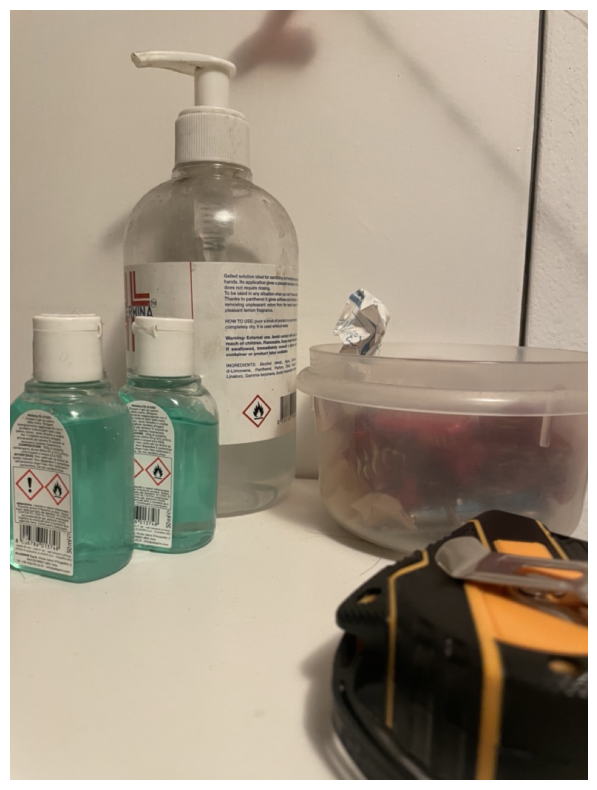

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(image)
plt.axis('off')
plt.show()

In [4]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() 
# Set input image 
ss.setBaseImage(image) 
# Use fast but lower quality method for initial filtering 
ss.switchToSelectiveSearchFast() 
# Get region proposals 
rects = ss.process()

2692


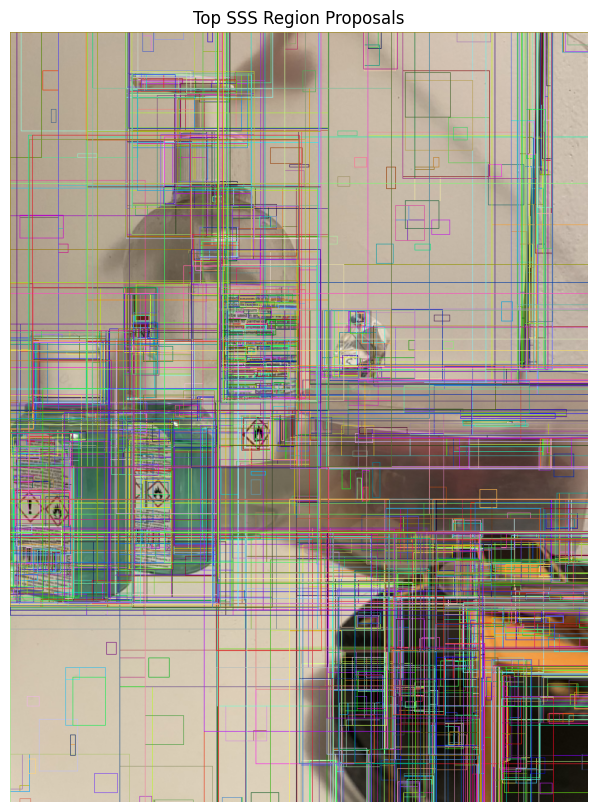

In [5]:
print(len(rects))
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

output = image.copy()

# Draw rectangles with random colors
for i, (x, y, w, h) in enumerate(rects):
	color = np.random.randint(0, 255, size=(3,), dtype=int).tolist()
	cv2.rectangle(output, (x, y), (x + w, y + h), color, thickness=1)
	
ax.imshow(output)
ax.set_title("Top SSS Region Proposals")
plt.axis('off')
plt.show()

In [6]:
print("Number of rectangles: ", len(rects))

# Remove rectangles too big
img_short_side = min(image.shape[0], image.shape[1])
max_pixel_size_perc = 0.05 ### EDIT ###
max_pixel_size = int(img_short_side * max_pixel_size_perc)
max_area = max_pixel_size ** 2

# Remove rectangles too unregular
max_aspect_ratio = 2 ### EDIT ###
min_aspect_ratio = 1/max_aspect_ratio

# Remove rectangles whose colors are too similar
max_color_stdev = 25 ### EDIT ###

rect_filtered = []
for i, (x, y, w, h) in enumerate(rects):
	if 0 < w * h < max_area and min_aspect_ratio < w / h < max_aspect_ratio:
		region_colors = image[y:y+h, x:x+w].reshape(-1, 3)
		stdev_colors = np.std(region_colors, axis=0)
		if np.all(stdev_colors > max_color_stdev):
			rect_filtered.append((x, y, w, h))

rect_filtered = np.array(rect_filtered)

print("Number of rectangles after filtering: ", len(rect_filtered))


Number of rectangles:  2692
Number of rectangles after filtering:  141


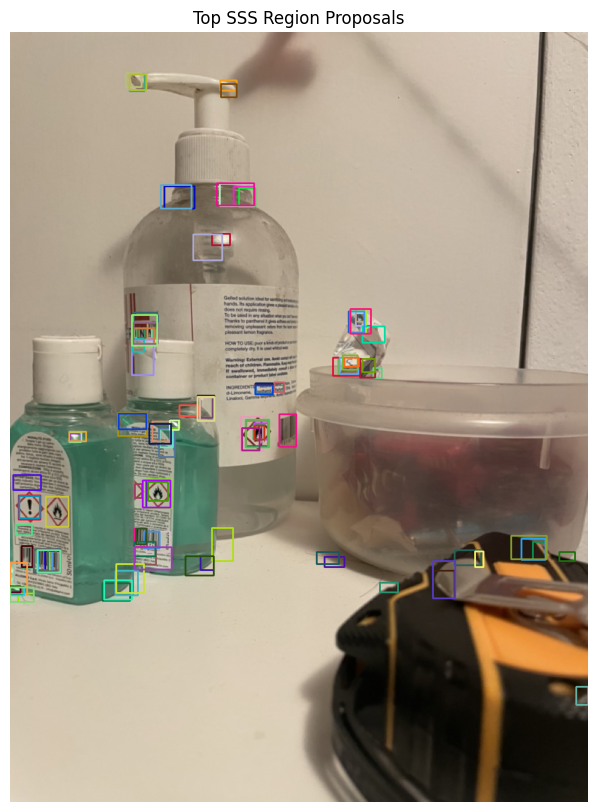

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

output = image.copy()

# Draw rectangles with random colors
for i, (x, y, w, h) in enumerate(rect_filtered):
	color = np.random.randint(0, 255, size=(3,), dtype=int).tolist()
	cv2.rectangle(output, (x, y), (x + w, y + h), color, thickness=2)
	
ax.imshow(output)
ax.set_title("Top SSS Region Proposals")
plt.axis('off')
plt.show()

In [42]:
def heuristic_score(rects, image, positive_colors, tolerance=175):
	scores = []
	# max_ratio_score = scipy_norm.pdf(1.0, loc=1.0, scale=0.35)
	for (x, y, w, h) in rects:
		
		
		# Color score: cluster the region by colors, compare centroids to positive colors
		region = image[y:y+h, x:x+w]
		pixels = region.reshape(-1, 3)

		dbscan = DBSCAN(eps=10)
		labels = dbscan.fit_predict(pixels)
		unique_labels = np.unique(labels[labels != -1])  # Exclude noise points (-1)
		centroids = np.array([pixels[labels == label].mean(axis=0) for label in unique_labels])
		print(centroids)
		print("-----")
		dists = np.linalg.norm(centroids[:, None, :] - np.array(positive_colors)[None, :, :], axis=2)
		print(dists)

		color_score = min(dists) if np.any(dists <= tolerance) else 0.0

		scores.append(color_score)
	return np.array(scores)

In [9]:
def nms(boxes, scores, overlapThresh):
    if len(boxes) == 0:
        return []

    boxes = boxes.astype(float)
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = x1 + boxes[:, 2]
    y2 = y1 + boxes[:, 3]
    area = boxes[:, 2] * boxes[:, 3]

    idxs = np.argsort(scores)  # ascending order
    
    pick = []
    while len(idxs) > 0:
        last = idxs[-1]
        pick.append(last)
        suppress = [last]
        for pos in idxs[:-1]:
            xx1 = max(x1[last], x1[pos])
            yy1 = max(y1[last], y1[pos])
            xx2 = min(x2[last], x2[pos])
            yy2 = min(y2[last], y2[pos])
            w = max(0, xx2 - xx1)
            h = max(0, yy2 - yy1)
            overlap = (w * h) / area[pos]
            if overlap > overlapThresh:
                suppress.append(pos)
        idxs = np.delete(idxs, [np.where(idxs == s)[0][0] for s in suppress])
    return boxes[pick].astype(int)

In [43]:
print("Number of rectangles after filtering: ", len(rect_filtered))

positive_colors = [
    [255,255,255], #WHITE
    [0,0,0], #BLACK
    [237,57,50], #GHS RED 1
	[255,3,28], #GHS RED 2
    [228,108,34], #GHS ORANGE 1
    [196,31,28], #GHS RED 3
    [66,166,56], #GHS GREEN 1
    [0,137,213], #GHS BLUE 1
    [244,237,54], #GHS YELLOW 1
	[255,2,16], #GHS RED 4|
    [237,41,47], #GHS RED 5
	]

scores = heuristic_score(rect_filtered, image, positive_colors)

rect_valid = rect_filtered[scores > 0]
scores_valid = scores[scores > 0]

print("Number of rectangles after color validation: ", len(rect_valid))

nms_filtered = nms(rect_valid, scores_valid, overlapThresh=0.3)

print("Number of rectangles after NMS: ", len(nms_filtered))


Number of rectangles after filtering:  141
[[125.59970015 145.16491754 125.90254873]]
-----
[[213.24712159 229.5639121  161.07227072 215.73180208 142.5241417
  166.05643518  94.19443315 153.06180639 166.1995484  222.07926835
  171.71478984]]
[[156.77073906 158.47586727 143.23303167]]
-----
[[177.3633308  264.96672715 159.45684101 217.0262302  139.833029
  176.2602713  126.11717353 172.93266716 147.43648574 224.32549808
  171.75013853]]
[[163.49185947 158.78663239 137.9991431 ]
 [233.         225.375      203.375     ]]
-----
[[176.97443998 266.43300515 153.32258296 211.52547388 132.50058109
  171.71492102 127.59527736 181.18878    140.19539082 218.72260696
  166.00596839]
 [ 63.45692437 382.68039047 227.79383497 284.06166804 206.13049568
  264.39937831 230.50765985 249.38280063 150.22992794 292.38635613
  241.79181386]]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

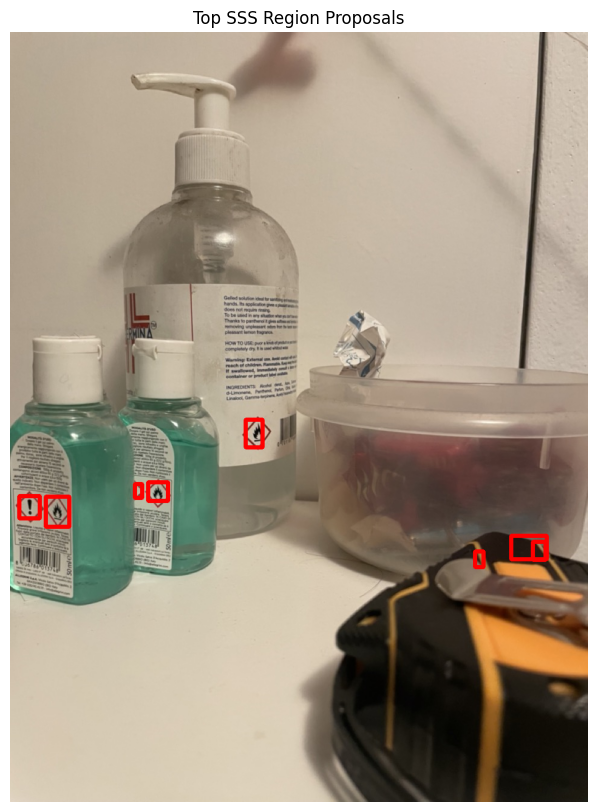

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

output = image.copy()

# Draw rectangles with random colors
for i, (x, y, w, h) in enumerate(nms_filtered):
	color = np.random.randint(0, 255, size=(3,), dtype=int).tolist()
	cv2.rectangle(output, (x, y), (x + w, y + h), [255,0,0], thickness=5)
	
ax.imshow(output)
ax.set_title("Top SSS Region Proposals")
plt.axis('off')
plt.show()

In [ ]:
# ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() 
# ss.setBaseImage(image) 
# size_strategy = cv2.ximgproc.segmentation.createSelectiveSearchSegmentationStrategySize()
# ss.addStrategy(size_strategy)
# ss.switchToSelectiveSearchFast(base_k=500, inc_k=500, sigma=1.5) 
# rects = ss.process()